In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Section 1: Data Generation

The goal of this section is to create a dataset with categorical features and a continuous target variable.

First, we create a normal dataset with some preset colinearity, including a target variable. These will simply be used as a base for the categorical variables

In [2]:
corr=.7 # Correlation of target variable to the feature bases
multicol= .4 #Correlation of the feature bases to each other
size = 10000 # number of samples

mvnorm = stats.multivariate_normal(mean=[0, 0, 0, 0, 0], cov=[[1., corr, corr, corr, corr], 
                                                           [corr, 1., multicol, multicol, multicol],
                                                           [corr, multicol, 1., multicol, multicol],
                                                           [corr, multicol, multicol, 1., multicol],
                                                           [corr, multicol, multicol, multicol, 1.]])
raw = mvnorm.rvs(size)

In [3]:
#Add to a dataframe and confirm that the correlations are close
#to our inputs:
normdf = pd.DataFrame(raw)
normdf.columns = ['target', 'norm1', 'norm2', 'norm3', 'norm4']
print(normdf.shape)
normdf.corr()

(10000, 5)


,target,norm1,norm2,norm3,norm4
target,1.000000,0.707913,0.699906,0.697794,0.694671
norm1,0.707913,1.000000,0.407601,0.411804,0.405650
norm2,0.699906,0.407601,1.000000,0.402795,0.390271
norm3,0.697794,0.411804,0.402795,1.000000,0.385198
norm4,0.694671,0.405650,0.390271,0.385198,1.000000


Next, we create some discrete distributions that will represent our categories. By creating different uniform/normalc ombinations as seen below, we ensure that we'll have categories occuring at different frequencies in the dataset.

In [4]:
#Create some categorical features from the feature bases, and sort them 
#The need for sorting will become apparent in a moment
cat1 = np.sort([np.round(x,0) for x in np.random.uniform(high=10.5, low=.5, size=size)])
cat2 = np.sort([np.round(x,0) for x in np.random.uniform(high=5.5, low=.5, size=size)])
cat3 = np.sort([np.round(x,0) for x in np.random.uniform(high=8.5, low=.5, size=size)])
cat4 = np.sort([np.ceil(x) for x in np.random.normal(loc=0, scale=2,size=size)])

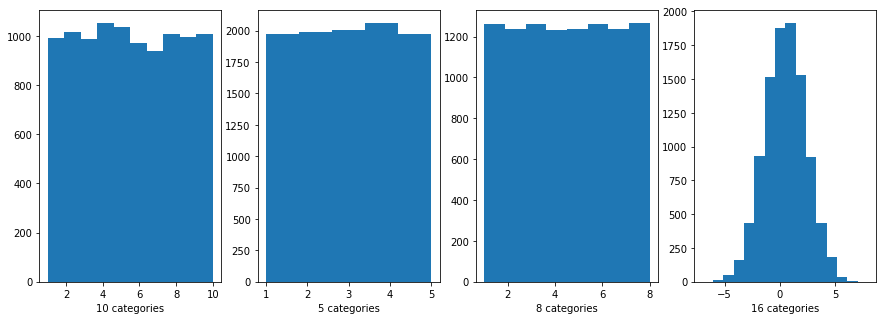

In [5]:
plt.figure(figsize=[15,5])
plt.subplot(141)
plt.hist(cat1, bins=10)
plt.xlabel(str(len(set(cat1)))+" categories")
plt.subplot(142)
plt.hist(cat2, bins=5)
plt.xlabel(str(len(set(cat2)))+" categories")
plt.subplot(143)
plt.hist(cat3, bins=8)
plt.xlabel(str(len(set(cat3)))+" categories")
plt.subplot(144)
plt.hist(cat4, bins=len(set(cat4)))
plt.xlabel(str(len(set(cat4)))+" categories")
plt.show()

By sorting the categories in the same order as the as the normal distributions generated with the multivariate function, we ensure that the categorical features will have a correlation with the target variable.

In [6]:
sortorder1 = stats.rankdata(normdf.norm1, method='ordinal')
sortorder2 = stats.rankdata(normdf.norm2, method='ordinal')
sortorder3 = stats.rankdata(normdf.norm3, method='ordinal')
sortorder4 = stats.rankdata(normdf.norm4, method='ordinal')

In [7]:
generic = pd.DataFrame({
    'target': normdf['target'],
    'feat1' : [int(cat1[i-1]) for i in sortorder1],
    'feat2' : [int(cat2[i-1]) for i in sortorder2],
    'feat3' : [int(cat3[i-1]) for i in sortorder3],
    'feat4' : [int(cat4[i-1]) for i in sortorder4]
})

### Result:
As seen below, the result of the above is a dataframe with 5 categorical variables that have strong correlations with a target variable, and moderate correlations with each other. We will convert the integers to text to obscure these relationships as a way ot simulating a real-life categorical situation.

In [8]:
generic.head()

,target,feat1,feat2,feat3,feat4
0,0.005885,4,3,6,1
1,-0.025222,3,5,4,1
2,-0.330986,4,1,5,1
3,-1.019336,5,1,7,-3
4,-0.307168,3,3,3,1


In [9]:
generic.corr()

,target,feat1,feat2,feat3,feat4
target,1.000000,0.686204,0.663832,0.669023,0.686182
feat1,0.686204,1.000000,0.379474,0.384255,0.388578
feat2,0.663832,0.379474,1.000000,0.370215,0.363393
feat3,0.669023,0.384255,0.370215,1.000000,0.362856
feat4,0.686182,0.388578,0.363393,0.362856,1.000000


In [10]:
#confirming the size of the categories we need to fake:
for col in generic.columns[1:]:
    print(col, set(generic[col]))
    print(len(set(generic[col])), "to create")

feat1 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
10 to create
feat2 {1, 2, 3, 4, 5}
5 to create
feat3 {1, 2, 3, 4, 5, 6, 7, 8}
8 to create
feat4 {0, 1, 2, 3, 4, 5, 6, 7, 8, -2, -7, -6, -5, -4, -3, -1}
16 to create


In [11]:
bestmove = ['three', 'layup', 'dunk', 'pass_oop', 'steal',
            'take_charge','midrange','pass_bounce','post_up','free_throw']
position = ['PG', 'SG', 'SF', 'PF', 'C']
sponsors = ['Nike','Reebok','Puma','Adidas','Air_Jordan','Fila','Under_Armour','AND1']
team = ['Knicks','Lakers','Bulls','Thunder','Heat','Clippers','Nets',
        'Rockets','Raptors','Hawks','Warriors','Blazers','Magic','Suns',
        'Celtics','Bobcats','76ers','Kings','Jazz','Spurs', 'Pistons', 'Bucks']
headband = ['Always','Sometimes','Never']
movie = ['Inception','The Prestige', 'The Matrix','The Avengers',
        'Pulp Fiction','The GodFather', 'Annihilation','Jaws']

In [12]:
df = pd.DataFrame({
    'all_star_votes': [int(x*10000+1e5) for x in generic['target']],
    'best_move': [bestmove[i-1] for i in generic['feat1']],
    'position': [position[i-1] for i in generic['feat2']],
    'shoe_sponsor': [sponsors[i-1] for i in generic['feat3']],
    'team': [team[i-1] for i in generic['feat4']],
    'wears_headband': [np.random.choice(headband) for _ in range(size)],
    'favorite_movie': [np.random.choice(movie) for _ in range(size)],
})
df.head()

,all_star_votes,best_move,position,shoe_sponsor,team,wears_headband,favorite_movie
0,100058,pass_oop,SF,Fila,Knicks,Sometimes,The Avengers
1,99747,dunk,C,Adidas,Knicks,Always,Inception
2,96690,pass_oop,PG,Air_Jordan,Knicks,Always,The GodFather
3,89806,steal,PG,Under_Armour,Jazz,Always,The Prestige
4,96928,dunk,SF,Puma,Knicks,Sometimes,The Prestige


# Section 2: PCA vs MCA for dimensionality Reduction with Categorical Variables

### One-hot encoded: Regression Baseline

In [13]:
y = df.all_star_votes
Xcat = df.drop('all_star_votes', axis=1)
X = pd.get_dummies(Xcat, drop_first=True)
print(X.shape)
X.head()

(10000, 44)


,best_move_free_throw,best_move_layup,best_move_midrange,best_move_pass_bounce,best_move_pass_oop,best_move_post_up,best_move_steal,best_move_take_charge,best_move_three,position_PF,...,team_Thunder,wears_headband_Never,wears_headband_Sometimes,favorite_movie_Inception,favorite_movie_Jaws,favorite_movie_Pulp Fiction,favorite_movie_The Avengers,favorite_movie_The GodFather,favorite_movie_The Matrix,favorite_movie_The Prestige
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [15]:
regr = LinearRegression()
regr.fit(X_train, y_train)

print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

0.8676923296481689
0.8711162436154479


In [16]:
lasso = LassoCV()
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8701285206009757

In [17]:
coefs = lasso.coef_
for i, col in enumerate(X.columns):
    print(col, ":", coefs[i])

best_move_free_throw : 8071.603101613531
best_move_layup : -934.355234698058
best_move_midrange : 3599.6767773934876
best_move_pass_bounce : 4554.937719322821
best_move_pass_oop : 936.7527003681366
best_move_post_up : 5800.176665892987
best_move_steal : 2045.0364841026128
best_move_take_charge : 2998.577555767746
best_move_three : -3739.0221017992335
position_PF : -2782.387549560606
position_PG : -9062.598471352883
position_SF : -4401.523500282184
position_SG : -6220.052706399883
shoe_sponsor_Adidas : -5655.632308554717
shoe_sponsor_Air_Jordan : -4785.379060997838
shoe_sponsor_Fila : -3921.250170824583
shoe_sponsor_Nike : -10668.562728105555
shoe_sponsor_Puma : -6798.865381346983
shoe_sponsor_Reebok : -8074.461327972626
shoe_sponsor_Under_Armour : -2477.426150691395
team_Bobcats : -3188.7048189233915
team_Bucks : 4843.108785627219
team_Bulls : 9333.064390237167
team_Celtics : -0.0
team_Clippers : 16051.039164141841
team_Heat : 13594.767129350059
team_Jazz : 11.877761345047443
team_King

## Analysis: 
This model has way too many parameters, and is therefore horrifically overfitting to the point of being useless. 
We need some way to reduce the dimensions.

### PCA

In [18]:
pca = PCA(n_components=10)

In [19]:
scaledX = StandardScaler().fit_transform(X)
pca_components = pca.fit_transform(scaledX)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [36]:
print([round(x,2) for x in pca.explained_variance_ratio_])
print(np.sum(pca.explained_variance_ratio_))

[0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
0.3034268544712074


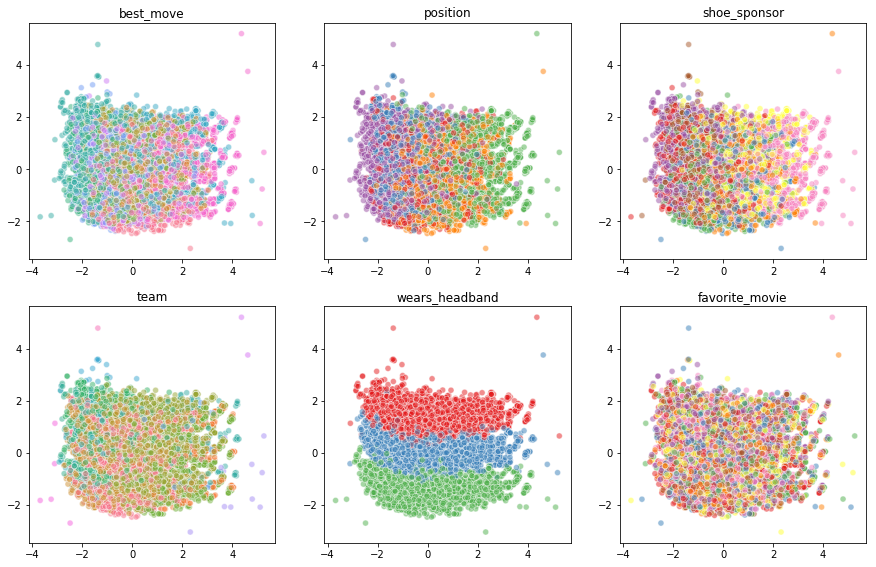

In [21]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

# MCA

In [22]:
mca = prince.MCA(n_components=10)
mca.fit(Xcat)

MCA(check_input=True, copy=True, engine='auto', n_components=10, n_iter=10,
  random_state=None)

In [23]:
mca.total_inertia_

7.333333333333333

In [35]:
print([round(x,2) for x in mca.explained_inertia_])
print(np.sum(mca.explained_inertia_))

[0.05, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
0.27205334409022364


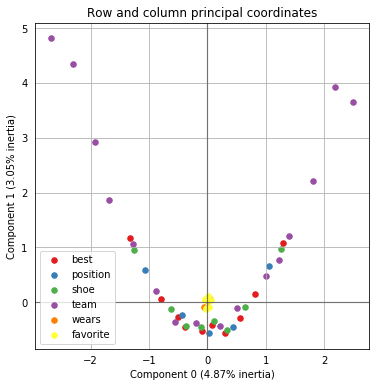

In [25]:
ac = mca.plot_coordinates(X=Xcat,
     ax=None,
     figsize=(6, 6),
     show_row_points=False,
     row_points_size=1,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1)

In [26]:
mca_components = mca.transform(Xcat)
mca_components.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.045543,-0.659060,0.358085,0.108138,-0.385516,-0.359742,0.066336,0.094542,-0.395562,0.409297
1,-0.166066,-0.107882,0.698464,-0.965566,0.707631,-0.420016,-0.052425,0.464489,0.082248,-0.282177
2,0.314311,-0.217241,-0.338779,-0.112968,0.001170,-0.258422,0.238904,0.013622,0.340064,0.741642
3,0.508779,0.314686,-0.393914,-0.826038,-0.792402,0.693373,-0.380089,0.303888,0.421313,-0.196089
4,0.212913,-0.633321,0.431210,0.009851,0.015332,0.398003,-0.151545,0.502889,-0.346854,-0.138027


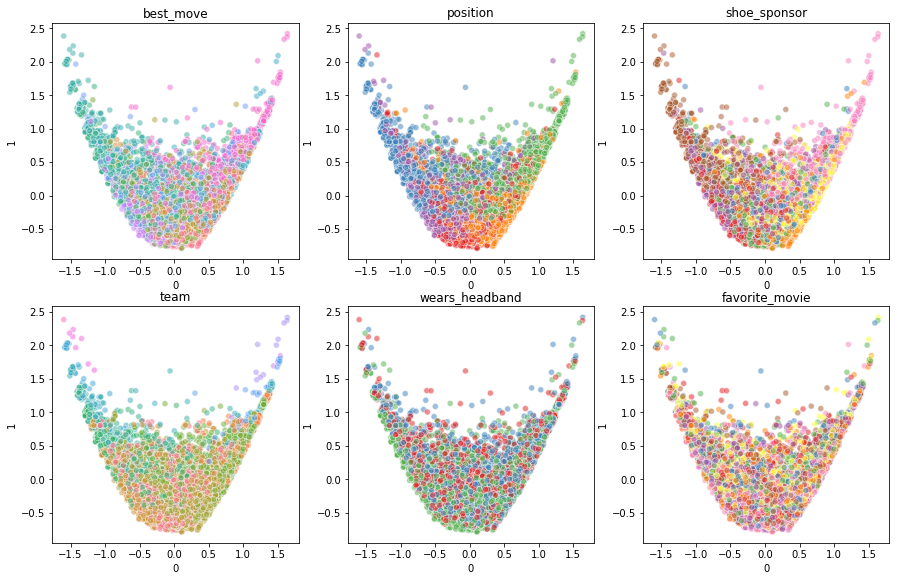

In [27]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=mca_components[0], y=mca_components[1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

# Comparing them both with a simple regression

In [28]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
    pca_components, y, test_size=0.33)

mca_X_train, mca_X_test, mca_y_train, mca_y_test = train_test_split(
    mca_components, y, test_size=0.33)

In [29]:
#PCA:
regr.fit(pca_X_train, pca_y_train)
print(regr.score(pca_X_train, pca_y_train))
print(regr.score(pca_X_test, pca_y_test))

0.7541578414403209
0.7625451654972644


In [30]:
#MCA:
regr.fit(mca_X_train, mca_y_train)
print(regr.score(mca_X_train, mca_y_train))
print(regr.score(mca_X_test, mca_y_test))

0.865312475624304
0.8693742500956148
